# Note
Previous notebook drafts have analyzed several classification methods not included here, particularly SVM methods. The SVM classifiers did not return quality results and took long times to run. They are therefore not included in this analysis.

# Defining Parameters

* **Data**: All Notes
* **Model Imbalance**: ADASYN
* **Vectorizor**: TF-IDF
* **Vectorizor Parameters**: 3000
* **Dimension Reduction Method**: Truncated SVD
* **Grid Search Scoring Parameter**: f1

In [1]:
scoring_metric = 'f1'
max_features = 3000
svd_features = 900
max_iter_log = 500

# Library Calls

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import feather
import nltk
import re
import string
import yellowbrick
import sklearn
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.features import RadViz

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate

from imblearn.over_sampling import ADASYN 

from collections import Counter

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

# Random State
rng = np.random.RandomState(5590)
solver_log = 'saga'

# Data Import and Processing
## !!!One Data Frame Import Must Be Commented Out!!!!

We define the dataframes as none for a subsqent check.

In [3]:
df_all = None
df_ds = None

In [4]:
# All Available Notes
df_all = pd.read_csv('./data/text_processed_all.csv.gz', compression='gzip', low_memory=False)

# Dishcharge Summary Notes Onlly
#df_ds = pd.read_csv('./data/text_processed_discharge_summary.csv.gz', compression='gzip', low_memory=False)

# Define Data Frame

Here we do a check to see which data frame we are analyzing, All Notes or Discharge Notes

In [5]:
if df_all is not None:
    df = df_all
else:
    df = df_ds
      
# Convert HADMID to String
df.hadm_id = df.hadm_id.astype('int64').astype(str)

# Convert Readmit_30 to Int
df.readmit_30 = df.readmit_30.astype('int')

# Functions

## Modified Tokenizer
Define a modified tokenizer function. This function will remove numbers and characters, as well as set all words to lower case.

In [6]:
def tokenize_note_events(text):
    #create a list of all characters and numbers
    num_puct_list = string.punctuation+'0123456789'
    
    # Create a dictionary aligning each numeric and chcarter to a space
    t = str.maketrans(dict.fromkeys(num_puct_list, " "))
    
    # Convert Text to lower case and apply dictionary
    text = text.lower().translate(t)
    
    #tokenize
    tokens = nltk.word_tokenize(text)
    return tokens

## Custom Stop Words
Define custom stop words

In [7]:
stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
 'is','patient','s','he','at','as','or','one','she','his','her','am', 
 'were','you','pt','pm','by','be','had','your','this','date', 'from',
 'there','an','that','p','are','have','has','h','but','o', 
 'namepattern','which','every','also', 'w', 'd', 'c', 'l', 
 'q', 'r', 'x', 't', 'm']

## Text Processing Function with Truncated SVD
The following function performs all of the prec-processing steps, using sub-sampling to balance the data. The function tokenizes the text using 1-grams and 2-grams. The function returns a processed predictor dataframe for the training and validation data, as well as the target variable for the training and validation data.

In [8]:
def text_processing_tr_v(df):
    # Clean the Entire Data Set of numbers, characters, carriage returns, and new lines
    df.text = df.text.fillna(' ')
    df.text = df.text.str.replace('\n',' ')
    df.text = df.text.str.replace('\r',' ')
    
    # Split into Train, Valid and Test
    ## Shuffle
    df = df.sample(n = len(df), random_state = rng)
    df = df.reset_index(drop = True)
    
    ## Extract Data for Test and Valid Sampling
    df_v_te = df.sample(frac=0.40, random_state = rng)
    
    ## Test Sample
    df_te = df_v_te.sample(frac = 0.5, random_state = rng)
    
    ## Valid Sample
    df_v = df_v_te.drop(df_te.index)

    ## Training Sample
    df_tr = df.drop(df_v_te.index)
    
    # Initialize Vectorizer and SVD
    ## Use Modified Tokenizer, Set number of n-grams, use custom stop words
    vect = TfidfVectorizer(max_features = max_features, 
                           tokenizer = tokenize_note_events, 
                           ngram_range = (1,2),
                           stop_words=stop_words
                          )

    # Transform Text
    # Fit Vectorizer on Training Data
    vect.fit(df_tr.text.values)
    
    # Transform the text into vectors.
    x_tr_tf = vect.transform(df_tr.text.values)
    x_v_tf = vect.transform(df_v.text.values)
    x_te_tf  = vect.transform(df_te.text.values)
    
    # Define Target Variables
    y_tr = df_tr.readmit_30
    y_v = df_v.readmit_30
    y_te = df_te.readmit_30
    
    return x_tr_tf, x_v_tf, x_te_tf, y_tr, y_v, y_te, df_tr, vect

## ADASYN Over Sampling

In [9]:
def asadyn_sample(x_train, y_train):
     # Initialize ADASYN 
    ada = ADASYN(random_state = rng)
    x_train_adasyn, y_tr_adasym = ada.fit_resample(x_train, y_train)
    
    return x_train_adasyn, y_tr_adasym

## Dimension Reduction: Truncated SVD

In [10]:
def trunc_svd(x_tr, x_v, x_te, n_components):
    svd = TruncatedSVD(n_components = n_components, random_state = rng)
    # Fit SVD on Training Data
    svd.fit(x_tr)
    
    # Transform Sparse Matrices
    x_tr_svd = svd.transform(x_tr)
    x_v_svd = svd.transform(x_v)
    x_te_svd  = svd.transform(x_te)
    
    return x_tr_svd, x_v_svd, x_te_svd, svd

## Model Output

### Scoring Metrics
The following functions calculate the scoring metrics the models will be evlauted on.

In [11]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

### Scoring Output
The following code generates the visual output of the scoring metrics.

In [12]:
def model_output(y_tr, y_tr_preds, y_tr_preds_prob, y_v, y_v_preds, y_v_preds_prob):
    
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_tr_preds_prob)
    fpr_v, tpr_v, thresholds_v = roc_curve(y_v, y_v_preds_prob)

    thresh = 0.5

    auc_t = '%.3f' %roc_auc_score(y_tr, y_tr_preds_prob)
    auc_v = '%.3f' %roc_auc_score(y_v, y_v_preds_prob)
    
    acc_t = '%.3f' %accuracy_score(y_tr, y_tr_preds)
    acc_v = '%.3f' %accuracy_score(y_v, y_v_preds)
        
    recall_t = '%.3f' %recall_score(y_tr, y_tr_preds)
    recall_v = '%.3f' %recall_score(y_v, y_v_preds)
        
    precision_t = '%.3f' %precision_score(y_tr, y_tr_preds)
    precision_v = '%.3f' %precision_score(y_v, y_v_preds)
      
    
    f1_t = '%.3f' %f1_score(y_tr, y_tr_preds)
    f1_v = '%.3f' %f1_score(y_v, y_v_preds)
    
    specificity_t = '%.3f' %calc_specificity(y_tr, y_tr_preds, thresh)
    specificity_v = '%.3f' %calc_specificity(y_v, y_v_preds, thresh)
    
    prevalence_t = '%.3f' %calc_prevalence(y_tr)
    prevalence_v = '%.3f' %calc_prevalence(y_v)
    
    
    data = {'Score':['AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity', 'Prevalence'],
            'Train':[auc_t, acc_t, precision_t, recall_t, f1_t, specificity_t, prevalence_t],
            'Validation':[auc_v, acc_v, precision_v, recall_v,  f1_v, specificity_v, prevalence_v]
           }
    
    df = pd.DataFrame(data)
    
    print(df)

    plt.plot(fpr_tr, tpr_tr,'r-', label = 'Train AUC: %.2f'%roc_auc_score(y_tr, y_tr_preds))
    plt.plot(fpr_v, tpr_v,'b-',label = 'Valid AUC: %.2f'%roc_auc_score(y_v, y_v_preds))
    plt.plot([0,1],[0,1],'-k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## Model Execution

The following function trains a default model to the training data and generates training and validation scores.

In [13]:
def train_model(clf, x_tr, x_v, y_tr, y_v):
    
    clf.fit(x_tr, y_tr)

    y_tr_preds = clf.predict(x_tr)
    y_v_preds = clf.predict(x_v)
    
    y_tr_preds_prob = clf.predict_proba(x_tr)[:,1]
    y_v_preds_prob = clf.predict_proba(x_v)[:,1]

    model_output(y_tr, y_tr_preds, y_tr_preds_prob, y_v, y_v_preds, y_v_preds_prob)

The following function runs the gridsearchcv

In [14]:
def grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyper_param_dict):

    # Create a Grid Search
    clf = GridSearchCV(clf, 
                       hyper_param_dict, 
                       cv=5, 
                       verbose=1, 
                       n_jobs = -1,
                       scoring = scoring_metric)

    # Best Model
    clf.fit(x_tr, y_tr)
    
    # Export Best Parameters to New Model
    clf_best_est = clf.best_estimator_

    print("Best parameters set found on training set:")
    print()
    print(clf.best_params_)
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    return clf_best_est

# Data Set: Discharge Notes
The following analysis will be of the data frame with all discharge notes.

## Data Processing

First the data is processed and tokenized. This will take a while.

In [15]:
df = df.sample(frac = 1, random_state = rng)
x_tr_pre, x_v_pre, x_te_pre, y_tr_pre, y_v_pre, y_te_pre, df_tr_non_xfrm, vect = text_processing_tr_v(df)

### Imbalance Data Set Method
Use ADASYN Oversampling to Correct the imbalance in the training data set.

In [16]:
x_tr_adasyn, y_tr_adasyn = asadyn_sample(x_tr_pre, y_tr_pre)

### Dimension Reduction

Then we reduce the dimensions of the sparse matrics to improve model run time.

For Discharge Summary, SVD is only used for surveying the default models. For All Notes, SVD is used for final outputs.

In [17]:
x_tr_adasyn_svd, x_v_svd, x_te_svd, svd_n = trunc_svd(x_tr_adasyn, x_v_pre, x_te_pre, svd_features)

Check the shape of the reduced data frame 

In [18]:
svd_var = '%.1f' %svd_n.explained_variance_ratio_.sum()
print('The explained variance of the Truncatved SVD dimension reduction using', 
      svd_features,'features is %.3f.' %svd_n.explained_variance_ratio_.sum())

The explained variance of the Truncatved SVD dimension reduction using 900 features is 0.907.


## Modeling - Default Settings

### Naive Bayes

#### Pre-SVD
Naive Bayes will not run with Truncated SVD due to negative matrix values.

In [19]:
# # Define X/Y Values
# x_tr = x_tr_adasyn
# x_v = x_v_pre
# y_tr = y_tr_adasyn
# y_v = y_v_pre

# train_model(clf, x_tr, x_v, y_tr, y_v)

### Logistic Regression

In [20]:
# # Define Classifier - Default Settings
# clf = LogisticRegression(random_state = rng, solver = solver_log, max_iter = max_iter_log)

#### SVD

In [21]:
# # Define X/Y Values
# x_tr = x_tr_adasyn_svd
# x_v = x_v_svd
# y_tr = y_tr_adasyn
# y_v = y_v_pre

# train_model(clf, x_tr, x_v, y_tr, y_v)

###  Random Forest

In [22]:
# Define Classifier - Default Settings
# clf = RandomForestClassifier(random_state = rng, n_estimators = 100)

#### SVD

In [23]:
# # Define X/Y Values
# x_tr = x_tr_adasyn_svd
# x_v = x_v_svd
# y_tr = y_tr_adasyn
# y_v = y_v_pre

# train_model(clf, x_tr, x_v, y_tr, y_v)

### Ada Boost Classifier

In [24]:
# # Define Classifier - Default Settings
# clf = AdaBoostClassifier(random_state = rng)

#### SVD

In [25]:
# x_tr = x_tr_adasyn_svd
# x_v = x_v_svd
# y_tr = y_tr_adasyn
# y_v = y_v_pre

# train_model(clf, x_tr, x_v, y_tr, y_v)

### XGBoost

In [26]:
# # Define Classifier - Default Settings
# clf = XGBClassifier(random_state = rng)

#### SVD

In [27]:
# x_tr = x_tr_adasyn_svd
# x_v = x_v_svd
# y_tr = y_tr_adasyn
# y_v = y_v_pre

# train_model(clf, x_tr, x_v, y_tr, y_v)

## Parameter Optimization

### Define X / Y Training and Validation Values

In [28]:
x_tr = x_tr_adasyn_svd
x_v = x_v_svd
y_tr = y_tr_adasyn
y_v = y_v_pre

### Naive Bayes

Naive Bayes cannot use the dimensionally reduced matrices due to negative values.

#### Define Function Inputs

In [29]:
# # Establish Classifier
# clf = MultinomialNB()

# #Define Parameters
# alpha = np.logspace(1, 5, 4)

# # Create hyperparameter options
# hyperparameters = dict(alpha = alpha)

In [30]:
# clf = grid_search_opt(x_tr_adasyn, x_v_pre, y_tr_adasyn, y_v_pre, clf, hyperparameters)

# train_model(clf, x_tr_adasyn, x_v_pre, y_tr_adasyn, y_v_pre)

# # Define for Test Analysis
# clf_nb_opt = clf

### KNNeighbors

#### Define Function Inputs

In [31]:
# # Establish Classifier
# clf = KNeighborsClassifier()

# #Define Parameters
# n_neighbors  = np.linspace(3,33,11).astype('int') 
# weights = ('uniform', 'distance')
# metric = ('euclidean', 'manhattan')

# # Create hyperparameter options
# hyperparameters = dict(n_neighbors = n_neighbors, weights = weights, metric = metric)

#### Pre SVD

In [32]:
# clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

# train_model(clf, x_tr, x_v, y_tr, y_v)

# # Define for Test Analysis
# clf_knn_opt = clf

### Logistic Regression

#### Define Function Inputs

In [33]:
# # Establish Classifier
# clf = LogisticRegression(random_state = rng, solver = solver_log, max_iter = max_iter_log)

# #Define Parameters
# penalty = ['l1','l2']       
# C = np.logspace(-5, 1, 7)

# # Create hyperparameter options
# hyperparameters = dict(C=C, penalty = penalty)

In [34]:
# clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

# train_model(clf, x_tr, x_v, y_tr, y_v)

# # Define for Test Analysis
# clf_logreg_opt = clf

### Random Forest

Random Forest models have so far performed so-so, and have taken a very long time to run. For the training data it often overfits to match 100%. I recommend commenting out these models until final analysis

#### Define Function Inputs

In [35]:
# # Establish Classifier
# clf = RandomForestClassifier(random_state = rng)

# #Define Parameters
# n_estimators = [100, 300, 500, 800, 1200]
# max_depth = [5, 8, 15, 25, 30]
# min_samples_split = [2, 5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10] 


# # Create hyperparameter options
# hyperparameters = dict(n_estimators=n_estimators, 
#                        max_depth=max_depth,
#                        min_samples_split = min_samples_split,
#                        min_samples_leaf = min_samples_leaf)

#### Pre SVD

In [36]:
# clf = grid_search_opt(x_tr, x_v, clf, hyperparameters)

# train_model(clf, x_tr, x_v)

# # Define for Test Analysis
# clf_rf_opt_pre = clf

### Ada Boost

#### Define Function Inputs

In [59]:
# Establish Classifier
clf = AdaBoostClassifier(random_state = rng)

#Define Parameters
n_estimators = [50, 100, 150, 200, 250]
learning_rate = np.logspace(-4, 2, 7)

# Create hyperparameter options
hyperparameters = dict(n_estimators=n_estimators, 
                       learning_rate=learning_rate)

#### Pre SVD

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 121.4min
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed: 594.3min finished


Best parameters set found on training set:

{'learning_rate': 1.0, 'n_estimators': 250}

0.625 (+/-0.032) for {'learning_rate': 0.0001, 'n_estimators': 50}
0.625 (+/-0.032) for {'learning_rate': 0.0001, 'n_estimators': 100}
0.625 (+/-0.032) for {'learning_rate': 0.0001, 'n_estimators': 150}
0.625 (+/-0.032) for {'learning_rate': 0.0001, 'n_estimators': 200}
0.625 (+/-0.032) for {'learning_rate': 0.0001, 'n_estimators': 250}
0.625 (+/-0.032) for {'learning_rate': 0.001, 'n_estimators': 50}
0.625 (+/-0.032) for {'learning_rate': 0.001, 'n_estimators': 100}
0.625 (+/-0.032) for {'learning_rate': 0.001, 'n_estimators': 150}
0.625 (+/-0.033) for {'learning_rate': 0.001, 'n_estimators': 200}
0.625 (+/-0.033) for {'learning_rate': 0.001, 'n_estimators': 250}
0.634 (+/-0.021) for {'learning_rate': 0.01, 'n_estimators': 50}
0.659 (+/-0.041) for {'learning_rate': 0.01, 'n_estimators': 100}
0.704 (+/-0.033) for {'learning_rate': 0.01, 'n_estimators': 150}
0.739 (+/-0.022) for {'learning_rate': 0.

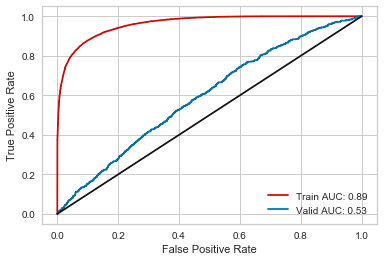

In [60]:
clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

train_model(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_ada_opt = clf

### XGBoost

#### Define Function Inputs

In [39]:
# # Establish Classifier
# clf = XGBClassifier(random_state = 5590)

# #Define Parameters
# n_estimators = [25, 50, 100, 150, 200]
# learning_rate = np.logspace(-4, 1, 6)

# # Create hyperparameter options
# hyperparameters = dict(n_estimators=n_estimators, learning_rate=learning_rate)

#### Pre SVD

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 147.7min finished


Best parameters set found on training set:

{'learning_rate': 1.0, 'n_estimators': 200}

0.624 (+/-0.031) for {'learning_rate': 0.0001, 'n_estimators': 25}
0.624 (+/-0.031) for {'learning_rate': 0.0001, 'n_estimators': 50}
0.624 (+/-0.031) for {'learning_rate': 0.0001, 'n_estimators': 100}
0.624 (+/-0.031) for {'learning_rate': 0.0001, 'n_estimators': 150}
0.624 (+/-0.031) for {'learning_rate': 0.0001, 'n_estimators': 200}
0.624 (+/-0.031) for {'learning_rate': 0.001, 'n_estimators': 25}
0.625 (+/-0.030) for {'learning_rate': 0.001, 'n_estimators': 50}
0.633 (+/-0.030) for {'learning_rate': 0.001, 'n_estimators': 100}
0.643 (+/-0.018) for {'learning_rate': 0.001, 'n_estimators': 150}
0.649 (+/-0.026) for {'learning_rate': 0.001, 'n_estimators': 200}
0.657 (+/-0.027) for {'learning_rate': 0.01, 'n_estimators': 25}
0.727 (+/-0.022) for {'learning_rate': 0.01, 'n_estimators': 50}
0.780 (+/-0.031) for {'learning_rate': 0.01, 'n_estimators': 100}
0.804 (+/-0.037) for {'learning_rate': 0.01,

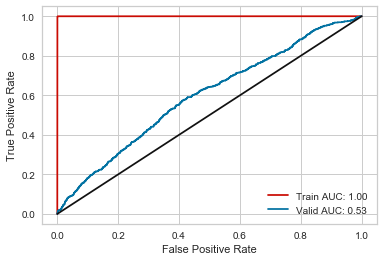

In [40]:
# clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

# train_model(clf, x_tr, x_v, y_tr, y_v)

# # Define for Test Analysis
# clf_xbg_opt = clf

# Test Set Scoring

### Define X/Y Values
For Naive Bayes, the pre-svd values will be used and insert manually. Global values for x and y will be defined here for the remaining models.

In [41]:
x = x_te_svd
y = y_te_pre

## General Function

In [42]:
def pretty_cm(y_pred, y_truth, labels):
    '''
    'Pretty' implementation of a confusion matrix with some evaluation statistics.
    
    Input:
    y_pred - object with class predictions from the model
    y_truth - object with actual classes
    labels - list containing label names
    '''
    
    cm = confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Confusion Matrix', size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    print('#######################')
    print('Evaluation metrics ####')
    print('#######################')
    print('Accuracy: {:.3f}'.format(accuracy_score(y_truth, y_pred)))
    print('AUC Score: {:.3f}'.format(roc_auc_score(y_truth, y_pred)))
    print('Precision: {:.3f}'.format(precision_score(y_truth, y_pred)))
    print('Recall: {:.3f}'.format(recall_score(y_truth, y_pred)))
    print('F1: {:.3f}'.format(f1_score(y_truth, y_pred)))
    print('Prevelance: {:.3f}'.format(calc_prevalence(y_truth)))

In [43]:
def test_score_cv(clf, x, y):
    scoring = ['roc_auc', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
    
    results = cross_validate(estimator = clf,
                                          X = x,
                                          y = y,
                                          cv = 5,
                                          scoring = scoring)
    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        print('%s : %.3f' % (metric_name, average_score))
    
    prevalence_te = '%.3f' %calc_prevalence(y)
    print('positive target prevalence: ', prevalence_te)

## Naive Bayes

In [44]:
# clf = clf_nb_opt

### Overall Metrics

In [45]:
# y_true, y_pred = y_te_pre, clf.predict(x_te_pre)
# pretty_cm(y_pred, y_true, [0, 1])

### Cross Validation

In [46]:
# test_score_cv(clf, x_te_pre, y_te_pre)

## KNNeighbors

In [47]:
# clf = clf_knn_opt

### Overall Metrics

In [48]:
# y_true, y_pred = y, clf.predict(x)
# pretty_cm(y_pred, y_true, [0, 1])

### Cross Validation

In [49]:
# test_score_cv(clf, x, y)

## Logistic Regression

In [50]:
# clf = clf_logreg_opt

### Overall Metrics

In [51]:
# y_true, y_pred = y, clf.predict(x)
# pretty_cm(y_pred, y_true, [0, 1])

### Cross Validation

In [52]:
# test_score_cv(clf, x, y)

## Ada Boost

In [61]:
clf = clf_ada_opt

### Overall Metrics

#######################
Evaluation metrics ####
#######################
Accuracy: 0.823
AUC Score: 0.548
Precision: 0.112
Recall: 0.230
F1: 0.151
Prevelance: 0.068


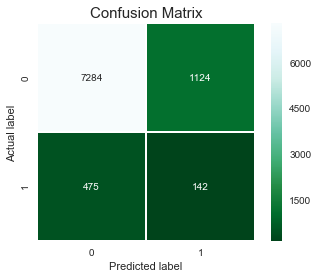

In [62]:
y_true, y_pred = y, clf.predict(x)
pretty_cm(y_pred, y_true, [0, 1])

### Cross Validation

In [63]:
test_score_cv(clf, x, y)

fit_time : 221.288
score_time : 9.812
test_roc_auc : 0.581
test_accuracy : 0.910
test_balanced_accuracy : 0.510
test_precision : 0.118
test_recall : 0.047
test_f1 : 0.067
positive target prevalence:  0.068


## XGBoost

In [56]:
# clf = clf_xbg_opt

### Overall Metrics

#######################
Evaluation metrics ####
#######################
Accuracy: 0.886
AUC Score: 0.525
Precision: 0.120
Recall: 0.107
F1: 0.113
Prevelance: 0.068


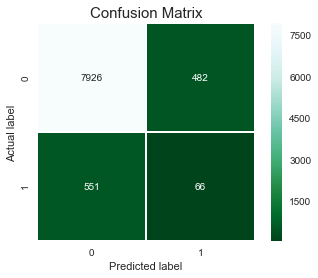

In [57]:
# y_true, y_pred = y, clf.predict(x)
# pretty_cm(y_pred, y_true, [0, 1])

### Cross Validation

In [58]:
# test_score_cv(clf, x, y)

fit_time : 63.925
score_time : 0.209
test_roc_auc : 0.583
test_accuracy : 0.923
test_balanced_accuracy : 0.505
test_precision : 0.136
test_recall : 0.021
test_f1 : 0.036
positive target prevalence:  0.068
